<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/reach_precip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By Carli Beisel

Created August, 2024

Purpose: Calculates precipitation for each Reach within Mason Drainage from PRISM.

## Gridmet

In [ ]:
# Installs geemap package
!pip install pycrs
import subprocess

try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as emap
except:
    import geemap as emap

# Authenticates and initializes Earth Engine
try:
    import wxee
except ImportError:
    print('wxee package not installed. Installing...')
    subprocess.check_call(['python','-m','pip','install','wxee'])
  #!pip install eemont

import ee
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project = 'ee-tvirrigation')

from google.colab import drive
drive.mount('/content/gdrive')

import wxee
import os

Mounted at /content/gdrive


In [14]:
!pip install geopandas
import geopandas as gpd
import json
import os
import numpy as np
import pandas as pd
!pip install pycrs
import pycrs
import seaborn as sns
import matplotlib.pyplot as plt

#Connect to Google Drive if you want to export images
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Mason Drainage shapefile

shp_file = '/content/gdrive/MyDrive/Data/GIS Shapefiles/Mason Creek/Mason Creek.shp'
mason = emap.shp_to_ee(shp_file) # converts shapefile to feature in GEE

map = emap.Map(center=(43.6150, -116.2023),zoom=8)
map.addLayer(ee.Image().paint(mason, 0, 2), {})
map.addLayerControl()
map

Map(center=[43.615, -116.2023], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

In [ ]:
# ------------------------------------#
# Daily Precipitation in Mason Drainage
# ------------------------------------#

# units = mm

mason_precip = []
gridmet = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate('2024-01-01', '2024-10-25')
gridmet_daily = gridmet.select('pr').map(lambda image: image.clip(mason))
mason_precip = gridmet_daily.toList(gridmet_daily.size())
mason_precip = ee.ImageCollection(mason_precip)
out_stats = os.path.join('/content/gdrive/MyDrive/Data/Mason Water Budget/data_input/precipitation/mason_precip_gridmet.csv')
emap.zonal_statistics(mason_precip, mason, out_stats, statistics_type='MEAN', scale=1000)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/precipitation/mason_precip_gridmet.csv


In [40]:
# ------------------------------------#
# Clean up CSV File
# ------------------------------------#

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/precipitation/mason_precip_gridmet.csv')
df = df.T.reset_index()
df.columns = ['Date', 'Precip (mm)']
df['Date'] = df['Date'].str.replace('_pr', '', regex=False)
df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/precip_out/mason_precip.csv', index=False)

In [ ]:
# Fixing weird things
df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/precip_out/mason_precip.csv')

df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='coerce')
df['Precip (mm)'] = pd.to_numeric(df['Precip (mm)'], errors='coerce')
df['Precip (inches)'] = df['Precip (mm)'] * 0.0393701
df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/precip_out/mason_precip.csv', index=False)

<ipython-input-51-d6efd402809f>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M', on='Date').sum(numeric_only=True)


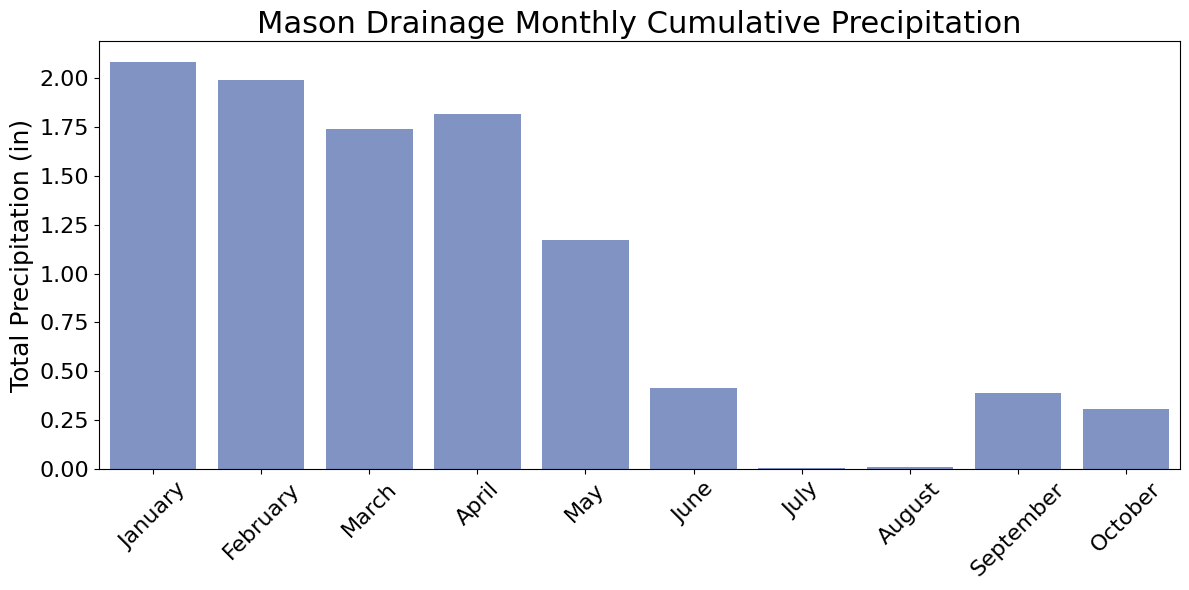

In [51]:
# ----- #
# Plot #
# ----- #

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/precip_out/mason_precip.csv')

# Ensure the Date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Group by year and month, and sum the precipitation for each month
df_monthly = df.resample('M', on='Date').sum(numeric_only=True)

# Add a 'Month' column with month names
df_monthly['Month'] = df_monthly.index.strftime('%B')

# Plotting the monthly total precipitation with month names on the x-axis
plt.figure(figsize=(12, 6))
sns.barplot(data=df_monthly.reset_index(), x='Month', y='Precip (inches)', color = '#758ECD')
plt.title('Mason Drainage Monthly Cumulative Precipitation', fontsize = 22)
plt.xlabel('')
plt.ylabel('Total Precipitation (in)', fontsize = 18)
plt.yticks(fontsize = 16)
plt.xticks(rotation=45, fontsize = 16)
plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/Data/Mason Water Budget/data_output/precip_out/mason_precip_plot.png', dpi=300, bbox_inches='tight')
plt.close()